In [493]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
import random
import cv2
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [494]:
# change the path according to your file location
file = open("tagPairsNewSorted.csv", 'r')
#file = open("", 'r')
line = file.readline().strip()
i, j = 0, 0
data = []
label = []

In [495]:
# pre-process data
tag_dict={}
for k in range(len(label)):
  tag_dict[k]=[k]
tag_dict

{}

In [496]:
dataLines = []
dataLines = file.readlines()
dataLines

i = 0
for line in dataLines:
  lineParts = line.strip().split(',')
  u, v = lineParts[1][1:], lineParts[2][:-1]
  count = int(lineParts[0])

  if u not in label:
    label.append(u)
  if v not in label:
    label.append(v)
  m, n = label.index(u), label.index(v)
  
  if u not in tag_dict:
    tag_dict[u] = [(label.index(v),count)]
  else:
    tag_dict[u].append((label.index(v), count))
  if v not in tag_dict:
    tag_dict[v] = [(label.index(u), count)]
  else:
    tag_dict[v].append((label.index(u), count))
  
  data.append(((label.index(u), label.index(v)), float(line[0])))

  i = i + 1
  if (i >= 500):
    break
  

In [497]:
encoded_array = np.zeros((len(label),len(label)), dtype=object)

In [498]:
# create embeddings
indexToKeyDict = {}
for key in tag_dict.keys():
  m=label.index(key) 
  indexToKeyDict[m] = key
  val=tag_dict[key]
  for i in val:
    encoded_array[m][i[0]]= i[1]

In [499]:
# implement scikit learn K-means on original embeddings
kmeans = KMeans(n_clusters=95, random_state=10).fit(encoded_array)
cluster_distribution=kmeans.labels_

In [500]:
# get cluster labels from clusters
def get_cluster_labels_scikit(cluster_distribution):
  clusters={}
  for i in range(len(cluster_distribution)):
    if cluster_distribution[i] not in clusters:
      clusters[cluster_distribution[i]]=[label[i]]
    else:
      clusters[cluster_distribution[i]].append(label[i])
  return clusters

In [501]:
clusters = get_cluster_labels_scikit(cluster_distribution)

In [502]:
# reduce dimension of the original embeddings
## 2. create a model
# Be very careful about 'perplexity' and 'metric' parameters
#tsne_model = TSNE(n_components=2,  metric='precomputed', perplexity = 50) # 
tsne_model = TSNE(n_components=2, metric='euclidean', perplexity = 50)
reduced_dims_tsne = tsne_model.fit_transform(encoded_array)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [503]:
# generate clusters using scikit-learn K-means on reduced dimension embeddings
kmeans_reduced = KMeans(n_clusters=95, random_state=10).fit(reduced_dims_tsne)
cluster_distribution = kmeans.labels_
clusters_reduced = get_cluster_labels_scikit(cluster_distribution)

In [504]:
clusters_reduced

{0: ['playframework'],
 1: ['python'],
 2: ['css'],
 3: ['pandas'],
 4: ['python3'],
 5: ['xcode'],
 6: ['javascript'],
 7: ['jquery'],
 8: ['ios'],
 9: ['php'],
 10: ['google-chrome',
  'nuxt.js',
  'google-maps',
  'npm',
  'google-apps-script',
  'jquery-ui',
  'coffeescript',
  'webpack',
  'promise',
  'html5-canvas',
  'chrome-extension',
  'firefox',
  'ecmascript-6',
  'axios',
  'bootstrap',
  'gulp',
  'internet-explorer',
  'd3.js',
  'dom',
  'next.js',
  '非同期',
  'websocket',
  'chart.js'],
 11: ['swift'],
 12: ['flask',
  'tkinter',
  '画像',
  'beautifulsoup',
  'vscode',
  'pyqt5',
  'python-requests'],
 13: ['html'],
 14: ['ajax'],
 15: ['c#'],
 16: ['visual-studio'],
 17: ['uitableview',
  'storyboard',
  'cocoapods',
  'xcode6',
  'ios8',
  'uicollectionview'],
 18: ['mysql'],
 19: ['objective-c'],
 20: ['java'],
 21: ['android'],
 22: ['tensorflow', '機械学習'],
 23: ['ruby-on-rails'],
 24: ['monaca'],
 25: ['cakephp'],
 26: ['android-studio'],
 27: ['swift3', 'swift4'],


In [505]:
# custom code
# source: https://github.com/tugot17/K-Means-Algorithm-From-Scratch/blob/master/K-means.ipynb?fbclid=IwAR3rTNK-GScsNMFprM3jYsj6vpQXzRKsc4McwpUBSMeb7CcAHvRlNPPGQj8
def get_initial_centroids(X, k):
    """
    Function picks k random data points from dataset X, recurring points are removed and replaced but new points
    so a result we have array of k unique points. Founded points can be used as intial centroids for k means algorithm
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        k (int): number of centroids

    Returns:
        (numpy.ndarray): array of k unique initial centroids, size K:D

    """
    number_of_samples = X.shape[0]
    sample_points_ids = random.sample(range(0, number_of_samples), k)

    centroids = [tuple(X[id]) for id in sample_points_ids]
    
    unique_centroids = list(set(centroids))

    number_of_unique_centroids = len(unique_centroids)

    while number_of_unique_centroids < k:
        new_sample_points_ids = random.sample(range(0, number_of_samples), k - number_of_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_sample_points_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))

        number_of_unique_centroids = len(unique_centroids)

    new_centroids = np.array(unique_centroids)
    # print("new_centroids::")
    # print(new_centroids)
    return new_centroids


In [506]:
# source: https://github.com/tugot17/K-Means-Algorithm-From-Scratch/blob/master/K-means.ipynb?fbclid=IwAR3rTNK-GScsNMFprM3jYsj6vpQXzRKsc4McwpUBSMeb7CcAHvRlNPPGQj8
def get_euclidean_distance(A_matrix, B_matrix):
    """
    Function computes euclidean distance between matrix A and B.
    E. g. C[2,15] is distance between point 2 from A (A[2]) matrix and point 15 from matrix B (B[15])
    Args:
        A_matrix (numpy.ndarray): Matrix size N1:D
        B_matrix (numpy.ndarray): Matrix size N2:D

    Returns:
        numpy.ndarray: Matrix size N1:N2
    """

    A_square = np.reshape(np.sum(A_matrix * A_matrix, axis=1), (A_matrix.shape[0], 1))
    # print("B_matrix::")
    # print(B_matrix * B_matrix)
    # print(type(B_matrix))
    #x = x[numpy.logical_not(numpy.isnan(x))]
    # B_matrix = B_matrix[np.logical_not(np.isnan(B_matrix))]
    # B_matrix = np.asmatrix(B_matrix)
    # print("B as matrix::")
    # print(B_matrix)
    B_square = np.reshape(np.sum(B_matrix * B_matrix, axis=1), (1, B_matrix.shape[0]))
    AB = A_matrix @ B_matrix.T

    C = -2 * AB + B_square + A_square

    return np.sqrt(C)

In [507]:
# source: https://github.com/tugot17/K-Means-Algorithm-From-Scratch/blob/master/K-means.ipynb?fbclid=IwAR3rTNK-GScsNMFprM3jYsj6vpQXzRKsc4McwpUBSMeb7CcAHvRlNPPGQj8
def get_clusters(X, centroids, distance_mesuring_method):
    """
    Function finds k centroids and assigns each of the N points of array X to one centroid
    Args:
        X (numpy.ndarray): array of sample points, size N:D
        centroids (numpy.ndarray): array of centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2

    Returns:
        dict {cluster_number: list_of_points_in_cluster}
    """

    k = centroids.shape[0]

    clusters = {}

    distance_matrix = distance_mesuring_method(X, centroids)

    closest_cluster_ids = np.argmin(distance_matrix, axis=1)

    for i in range(k):
        clusters[i] = []

    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])

    return clusters

In [508]:
# source: https://github.com/tugot17/K-Means-Algorithm-From-Scratch/blob/master/K-means.ipynb?fbclid=IwAR3rTNK-GScsNMFprM3jYsj6vpQXzRKsc4McwpUBSMeb7CcAHvRlNPPGQj8
def has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta):
    """
    Function checks if any of centroids moved more then MOVEMENT_THRESHOLD_DELTA if not we assume the centroids were founded
    Args:
        previous_centroids (numpy.ndarray): array of k old centroids, size K:D
        new_centroids (numpy.ndarray): array of k new centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered


    Returns: boolean True if centroids coverd False if not

    """
    distances_between_old_and_new_centroids = distance_mesuring_method(previous_centroids, new_centroids)
    # print("---------start--------")
    # print(distances_between_old_and_new_centroids.diagonal())
    # print (np.max(distances_between_old_and_new_centroids.diagonal()))
    # print(np.max(distances_between_old_and_new_centroids.diagonal()) <= movement_threshold_delta)
    # print("---------start--------")
    centroids_covered = True
    if (math.isnan(np.max(distances_between_old_and_new_centroids.diagonal()))):
      centroids_covered = True
    else:
      centroids_covered = np.max(distances_between_old_and_new_centroids.diagonal()) <= movement_threshold_delta

    return centroids_covered

In [509]:
# source: https://github.com/tugot17/K-Means-Algorithm-From-Scratch/blob/master/K-means.ipynb?fbclid=IwAR3rTNK-GScsNMFprM3jYsj6vpQXzRKsc4McwpUBSMeb7CcAHvRlNPPGQj8
def perform_k_means_algorithm(X, k, distance_mesuring_method, movement_threshold_delta=0):
    """
    Function performs k-means algorithm on a given dataset, finds and returns k centroids
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2.
        k (int): number of centroids
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered

    Returns:
        (numpy.ndarray): array of k centroids, size K:D
    """

    new_centroids = get_initial_centroids(X=X, k=k)

    centroids_covered = False

    while not centroids_covered:
        previous_centroids = new_centroids
        clusters = get_clusters(X, previous_centroids, distance_mesuring_method)

        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta)

    return new_centroids

In [510]:
# find labels from clusters
def get_cluster_labels(X, clusters):
  clustersLabels = {}
  rowIndexToCluster = {}
  for key in clusters:
    labelList = []
    # print("cluster:: " + str(key))
    # print(key, str(clusters[key]))
    values = clusters[key]
    for value in values:
      # print("single value::")
      # print(value)
      indexes = np.where(X == value)
      try:
        rowIndex = indexes[0][0]
        rowIndexToCluster[rowIndex] = key
        # print("rowIndex")
        # print(rowIndex)
        # print("key")
        # print(indexToKeyDict[rowIndex])
        labelList.append(indexToKeyDict[rowIndex])
      except:
        print("exceptions")
      # print("indexes::")
      # print(str(indexes))
    clustersLabels[key] = labelList
  return clustersLabels, rowIndexToCluster

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


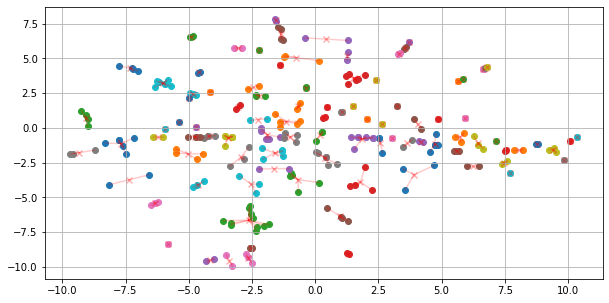

In [512]:
# find clusters using custom K-means 
k = 95

#X, _ = make_blobs(n_samples=1000, n_features=2, centers=k)
X = reduced_dims_tsne
centroids = perform_k_means_algorithm(X, k, movement_threshold_delta=0.1, distance_mesuring_method=get_euclidean_distance)

clusters = get_clusters(X, centroids, get_euclidean_distance)
# print(clusters)
cluster_labels, rowIndexToCluster = get_cluster_labels(X, clusters)


# print("cluster_labels")
# print(cluster_labels)
color = np.array(np.random.randint(1000, size=(k)))
# print("color", color)

plt.rcParams['figure.figsize'] = [10, 5]
i = 0
colors = ['#DF2020', '#81DF20', '#2095DF']
for centroid, points in clusters.items():
    points = np.array(points)
    centroid = np.mean(points, axis=0)

    localColorList = []
    for j in range(len(points)):
      # print("color[:i]::", color[i])
      localColorList.append(color[i]/255.)
    # print(localColorList)

    cc = np.random.randint(3)
    # print(cc)
    plt.scatter(points[:, 0], points[:, 1], marker='o')
    # print(points)
    for val in points:
      # print(val)
      x = [val[0], centroid[0]]
      y = [val[1], centroid[1]]
      plt.plot(x, y, c="red", alpha=0.2)
    i = i + 1
    plt.grid()
    plt.scatter(centroid[0], centroid[1], marker='x', color="red", alpha=0.3)

    # x = [points[:0], centroid[0]]
    # y = [points[:1], centroid[1]]
    # plt.plot(x, y, c="green", alpha=0.2)

plt.show()

In [513]:
# custom k-means results
cluster_labels

{0: ['c++', 'c'],
 1: ['nginx', 'capistrano', 'unicorn'],
 2: ['swiftui',
  'uitableview',
  'swift5',
  'spritekit',
  'firebase',
  'xcode7',
  'storyboard',
  'cocoapods',
  'xcode6',
  'ios8',
  'uicollectionview'],
 3: ['api'],
 4: ['google-colaboratory', 'pyqt'],
 5: ['sympy', 'pip', 'pytorch'],
 6: ['postgresql', 'oracle', 'sql-server'],
 7: ['unix', 'debian'],
 8: ['bash'],
 9: ['google-spreadsheet',
  'push-notification',
  'dart',
  'autolayout',
  'uinavigationcontroller'],
 10: ['tensorflow', '機械学習'],
 11: ['anaconda', 'csv'],
 12: ['emacs', 'elisp', 'android-fragments', 'webview', 'flutter'],
 13: ['virtualbox'],
 14: ['swift', 'objective-c'],
 15: ['centos'],
 16: ['ios', 'swift3', 'swift4'],
 17: ['xaml', 'xamarin', 'linq', 'mvc', 'entity-framework', '.net-core'],
 18: ['opencv', 'アルゴリズム'],
 19: ['windows'],
 20: ['node.js', 'vue.js', 'reactjs', 'ajax', 'json', 'typescript'],
 21: ['nuxt.js', 'jquery-ui', 'axios', 'bootstrap'],
 22: ['powershell', 'batch-file', 'windows-

In [514]:
def createRowIndexToClusterList(rowIndexToCluster):
  rowIndexToClusterList = []
  print(rowIndexToCluster)
  for i in range(len(rowIndexToCluster)):
    try:
      rowIndexToClusterList.append(rowIndexToCluster[i])
    except:
      rowIndexToClusterList.append(i)
  return rowIndexToClusterList

In [515]:
rowIndexToClusterList = createRowIndexToClusterList(rowIndexToCluster)
rowIndexToClusterList.append(0)

{48: 0, 49: 0, 106: 1, 173: 1, 177: 1, 93: 2, 95: 2, 120: 2, 123: 2, 135: 2, 151: 2, 152: 2, 176: 2, 180: 2, 182: 2, 194: 2, 119: 3, 133: 4, 137: 4, 88: 5, 91: 5, 92: 5, 94: 6, 112: 6, 166: 6, 146: 7, 159: 7, 89: 8, 155: 9, 165: 9, 184: 9, 234: 9, 245: 9, 33: 10, 35: 10, 42: 11, 51: 11, 96: 12, 97: 12, 160: 12, 178: 12, 183: 12, 150: 13, 4: 14, 12: 14, 41: 15, 9: 16, 28: 16, 39: 16, 139: 17, 140: 17, 168: 17, 201: 17, 223: 17, 237: 17, 59: 18, 69: 18, 63: 19, 25: 20, 46: 20, 47: 20, 53: 20, 61: 20, 68: 20, 104: 21, 144: 21, 203: 21, 206: 21, 128: 22, 147: 22, 154: 22, 75: 23, 21: 24, 66: 25, 82: 25, 29: 26, 31: 26, 26: 27, 17: 28, 132: 29, 117: 30, 72: 31, 142: 31, 158: 32, 179: 32, 195: 32, 175: 33, 189: 33, 126: 34, 225: 34, 22: 35, 32: 35, 50: 36, 55: 36, 190: 37, 198: 37, 218: 37, 227: 38, 238: 38, 241: 38, 243: 38, 196: 39, 215: 39, 37: 40, 90: 40, 102: 40, 186: 41, 207: 41, 86: 42, 109: 42, 107: 43, 163: 43, 167: 43, 171: 43, 205: 43, 221: 43, 40: 44, 138: 44, 143: 45, 193: 45, 1

In [516]:
# uncomment this code to generate silhouette_score for custome K-means
# silhouette_avg_custom = silhouette_score(reduced_dims_tsne, rowIndexToClusterList)

In [517]:
#silhouette_avg_custom

In [518]:
# uncomment this code to calculate davies_bouldin_score for custom K-means
#davies_bouldin_score_avg = davies_bouldin_score(reduced_dims_tsne, rowIndexToClusterList)

In [519]:
#davies_bouldin_score_avg

In [520]:
## uncomment this code to get davies_bouldin_score for sklear K-means
# kmeans = KMeans(n_clusters=95, random_state=10)
# # centroids, cluster_labels = (reduced_dims_tsne, 4)
# cluster_labels=kmeans.fit_predict(reduced_dims_tsne)
# silhouette_score(reduced_dims_tsne, cluster_labels)
# davies_bouldin_score_avg2 = davies_bouldin_score(reduced_dims_tsne, cluster_labels)

In [521]:
# davies_bouldin_score_avg2

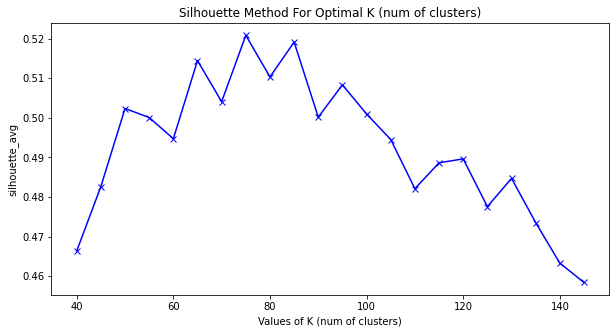

In [522]:

# find optimal K (number of clusters)
k_range=list(range(40,150,5))
silhouette_avg=[]
Sum_of_squared_distances=[]
for num_clusters in k_range:
  kmeans = KMeans(n_clusters=num_clusters, random_state=10)
  # centroids, cluster_labels = (reduced_dims_tsne, 4)
  cluster_labels=kmeans.fit_predict(reduced_dims_tsne)
  # custom code
  # centroids = perform_k_means_algorithm(X, k, movement_threshold_delta=0.3, distance_mesuring_method=get_euclidean_distance)
  # clusters = get_clusters(X, centroids, get_euclidean_distance)
  # print(cluster_labels)
  # cluster_labels = get_cluster_labels(X, clusters)
  silhouette_avg.append(silhouette_score(reduced_dims_tsne, cluster_labels))

plt.plot(k_range,silhouette_avg,'bx-')
plt.xlabel('Values of K (num of clusters)') 
plt.ylabel('silhouette_avg') 
plt.title('Silhouette Method For Optimal K (num of clusters)')
plt.show()